<a href="https://colab.research.google.com/github/Vineetiitg/Real-time-Toxic-Chat-Moderation-System/blob/main/Toxic_Chat_Detection_using_RoBERTa(LoRA_PEFT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Toxic_Chat_Detection_using_RoBERTausing LoRA fine Tuning (Active Development)

In [ ]:
!pip install transformers[datasets,evaluate]
!pip install peft

In [ ]:
# importing libraries
import pandas as pd
import spacy
import numpy as np
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
#from keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/train.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/processed_data_for_model.csv')

In [ ]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7979 entries, 0 to 7978
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   comment_text         7979 non-null   object
 1   toxic                7979 non-null   int64 
 2   severe_toxic         7979 non-null   int64 
 3   obscene              7979 non-null   int64 
 4   threat               7979 non-null   int64 
 5   insult               7979 non-null   int64 
 6   identity_hate        7979 non-null   int64 
 7   processed_comment    7979 non-null   object
 8   processed_comment_2  7979 non-null   object
 9   class                7979 non-null   int64 
 10  lemma_comment        7979 non-null   object
 11  final_comment        7978 non-null   object
dtypes: int64(7), object(5)
memory usage: 748.2+ KB


In [ ]:

from sklearn.model_selection import train_test_split


# filter out 20% of the data while class proportions balaced
remaining_df, filtered_df = train_test_split(
    df,
    test_size=0.06,
    stratify=df['class'],
    random_state=42
)

print(f"Original distribution:\n{df['class'].value_counts()}")
print(f"Filtered distribution:\n{filtered_df['class'].value_counts()}")

Original distribution:
class
0    7168
2     677
1     134
Name: count, dtype: int64
Filtered distribution:
class
0    430
2     41
1      8
Name: count, dtype: int64


In [ ]:
from transformers import RobertaTokenizerFast
import numpy as np

# 1. Initialize a tokenizer by loading the pre-trained 'roberta-base' tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# 2. Tokenize the df['final_comment'] column
max_length = 128 # Define a suitable maximum length
tokenized_data = tokenizer(list(df['final_comment'].fillna('')), # Fill NaN with empty string
                           truncation=True,
                           padding='max_length',
                           max_length=max_length,
                           return_tensors='np' # Return numpy arrays
                          )

# 3. Extract the input IDs, attention masks
input_ids = tokenized_data['input_ids']
attention_mask = tokenized_data['attention_mask']

labels = df['class'].to_numpy()

print("Tokenization complete.")
print(f"Shape of input_ids: {input_ids.shape}")
print(f"Shape of attention_mask: {attention_mask.shape}")
print(f"Shape of labels: {labels.shape}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Tokenization complete.
Shape of input_ids: (7979, 128)
Shape of attention_mask: (7979, 128)
Shape of labels: (7979,)


## Split Data for RoBERTa Models

In [ ]:
from sklearn.model_selection import train_test_split

# Split input_ids, attention_mask, and labels into training and testing sets
train_input_ids, val_input_ids, train_attention_mask, val_attention_mask, train_labels, val_labels = train_test_split(
    input_ids,
    attention_mask,
    labels,
    test_size=0.2,    # 20% for testing
    random_state=42
)

print("Data split into training and validation sets.")
print(f"Shape of train_input_ids: {train_input_ids.shape}")
print(f"Shape of val_input_ids: {val_input_ids.shape}")
print(f"Shape of train_labels: {train_labels.shape}")
print(f"Shape of val_labels: {val_labels.shape}")

In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments

# Custom Dataset class for RoBERTa inputs
class HateSpeechDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create training and validation datasets
train_dataset = HateSpeechDataset(train_input_ids, train_attention_mask, train_labels)
val_dataset = HateSpeechDataset(val_input_ids, val_attention_mask, val_labels)

print("Custom Dataset classes created and datasets initialized.")

In [ ]:
import numpy as np
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments

# 3. pre-trained 'roberta-base' model]
num_labels = len(np.unique(labels)) # Automatically determine the number of classes
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)

# 4. TrainingArguments
training_args = TrainingArguments(
    output_dir='./results_roberta_base',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_roberta_base',
    logging_steps=100,

    report_to="none" # Disable  W&B
)

# 5. Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    # compute_metrics=None,
)

# 6. Call the train() method to start the finetuning process
print("Starting RoBERTa base model training...")
trainer.train()
print("RoBERTa base model training complete.")

# 7.  evaluate the model on the validation set
print("Evaluating RoBERTa base model on validation set...")
eval_results = trainer.evaluate()
print(f"RoBERta Base Model Evaluation Results: {eval_results}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting RoBERTa base model training...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


RoBERTa base model training complete.
Evaluating RoBERTa base model on validation set...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


RoBERta Base Model Evaluation Results: {'eval_loss': 0.4986439645290375, 'eval_runtime': 38.3532, 'eval_samples_per_second': 2.503, 'eval_steps_per_second': 0.156, 'epoch': 3.0}


In [ ]:
import os

# directory to save the model and tokenizer
roberta_base_model_path = './roberta_base_model'
os.makedirs(roberta_base_model_path, exist_ok=True)

# Save the trained model
model.save_pretrained(roberta_base_model_path)
print(f"RoBERTa base model saved to {roberta_base_model_path}")

# Save the tokenizer
tokenizer.save_pretrained(roberta_base_model_path)
print(f"RoBERTa tokenizer saved to {roberta_base_model_path}")

RoBERTa base model saved to ./roberta_base_model
RoBERTa tokenizer saved to ./roberta_base_model


In [ ]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model
import numpy as np

num_labels = len(np.unique(labels))
lora_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)

# 2. Configure LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)


lora_model = get_peft_model(lora_model, lora_config)
print("LoRA-enabled model summary:")
lora_model.print_trainable_parameters()

# 4. Define TrainingArguments for this LoRA finetuning process
training_args_lora = TrainingArguments(
    output_dir='./results_roberta_lora',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_roberta_lora',
    logging_steps=100,
    report_to="none"
)

# 5. Initialize a Trainer with the LoRA-enabled model
trainer_lora = Trainer(
    model=lora_model,
    args=training_args_lora,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# 6. Call the train() method to start the LoRA finetuning process
print("Starting LoRA-enabled RoBERTa model training...")
trainer_lora.train()
print("LoRA-enabled RoBERTa model training complete.")

# 7. After training, evaluate the LoRA-finetuned model on the validation set
print("Evaluating LoRA-enabled RoBERTa model on validation set...")
eval_results_lora = trainer_lora.evaluate()
print(f"LoRA-enabled RoBERTa Model Evaluation Results: {eval_results_lora}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA-enabled model summary:
trainable params: 887,811 || all params: 125,535,750 || trainable%: 0.7072
Starting LoRA-enabled RoBERTa model training...


Step,Training Loss


LoRA-enabled RoBERTa model training complete.
Evaluating LoRA-enabled RoBERTa model on validation set...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LoRA-enabled RoBERTa Model Evaluation Results: {'eval_loss': 0.9203336834907532, 'eval_runtime': 40.2112, 'eval_samples_per_second': 2.387, 'eval_steps_per_second': 0.149, 'epoch': 3.0}


In [ ]:
import os

# directory to save the LoRA-enabled model and tokenizer
roberta_lora_model_path = './roberta_lora_model'
os.makedirs(roberta_lora_model_path, exist_ok=True)

# Save the trained LoRA model
lora_model.save_pretrained(roberta_lora_model_path)
print(f"LoRA-enabled RoBERTa model saved to {roberta_lora_model_path}")

# Save the tokenizer (using the same tokenizer as for the base model, as it's typically the same)
tokenizer.save_pretrained(roberta_lora_model_path)
print(f"RoBERTa tokenizer saved to {roberta_lora_model_path}")

LoRA-enabled RoBERTa model saved to ./roberta_lora_model
RoBERTa tokenizer saved to ./roberta_lora_model


In [ ]:
import torch
import torch.nn.functional as F

# Generate predictions (logits) from the trained RoBERTa base model on the validation set
roberta_base_predictions_output = trainer.predict(val_dataset)

# Extract logits
roberta_base_logits = roberta_base_predictions_output.predictions

# Convert logits to probabilities using softmax
roberta_base_predictions_proba = F.softmax(torch.tensor(roberta_base_logits), dim=-1).numpy()

print("RoBERTa base model predictions generated.")
print(f"Shape of RoBERTa base predictions: {roberta_base_predictions_proba.shape}")
print("First 5 predictions (probabilities per class):\n", roberta_base_predictions_proba[:5])

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


RoBERTa base model predictions generated.
Shape of RoBERTa base predictions: (96, 3)
First 5 predictions (probabilities per class):
 [[0.94689614 0.01077101 0.04233277]
 [0.9465913  0.0114644  0.04194422]
 [0.9426667  0.01162741 0.04570593]
 [0.9409075  0.01120125 0.04789128]
 [0.93771774 0.01254337 0.04973888]]


In [ ]:
import torch
import torch.nn.functional as F

# Generate predictions (logits) from the trained LoRA-enabled RoBERTa model on the validation set
lora_predictions_output = trainer_lora.predict(val_dataset)

# Extract logits
lora_logits = lora_predictions_output.predictions

# Convert logits to probabilities using softmax
lora_predictions_proba = F.softmax(torch.tensor(lora_logits), dim=-1).numpy()

print("LoRA-enabled RoBERTa model predictions generated.")
print(f"Shape of LoRA predictions: {lora_predictions_proba.shape}")
print("First 5 predictions (probabilities per class):\n", lora_predictions_proba[:5])

LoRA-enabled RoBERTa model predictions generated.
Shape of LoRA predictions: (96, 3)
First 5 predictions (probabilities per class):
 [[0.4205715  0.29428235 0.28514615]
 [0.4147912  0.29927173 0.285937  ]
 [0.41744095 0.29453313 0.28802598]
 [0.41958925 0.29747298 0.2829377 ]
 [0.4211848  0.29426754 0.2845477 ]]


In [ ]:
from sklearn.model_selection import train_test_split


_, val_df_indices, _, val_original_labels = train_test_split(
    df.index, # Split indices
    df['class'].to_numpy(),
    test_size=0.2,
    random_state=42
)

# Ensure val_labels from RoBERTa step matches val_original_labels
if not np.array_equal(val_labels, val_original_labels):
    print("Warning: val_labels and val_original_labels are not identical. Check split alignment.")

# 2. Create a new test set for the BiLSTM model using the `final_comment` texts
val_final_tweet_texts = df.loc[val_df_indices, 'final_comment'].fillna('').to_list()

# Apply one-hot encoding and padding for BiLSTM input
one_hot_representation_aligned = [one_hot(words, vocab_size) for words in val_final_tweet_texts]
embedded_tweet_aligned = pad_sequences(one_hot_representation_aligned, padding='pre', maxlen = sentence_length)

# 3. Generate predictions (probabilities) from the BiLSTM model on test set
bilstm_predictions_proba_aligned = bilstm_model.predict(embedded_tweet_aligned)

# 4. Ensure compatible shapes
print(f"Shape of bilstm_predictions_proba_aligned: {bilstm_predictions_proba_aligned.shape}")
print(f"Shape of roberta_base_predictions_proba: {roberta_base_predictions_proba.shape}")

# 5. Concatenate predictions to form the feature set for the stacking model
X_stacking = np.concatenate((
    bilstm_predictions_proba_aligned,
    roberta_base_predictions_proba
), axis=1)

# 6. The true labels for the stacking model will be val_labels
y_stacking = val_labels

print("Data for stacking model prepared successfully.")
print(f"Shape of X_stacking: {X_stacking.shape}")
print(f"Shape of y_stacking: {y_stacking.shape}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Shape of bilstm_predictions_proba_aligned: (96, 3)
Shape of roberta_base_predictions_proba: (96, 3)
Data for stacking model prepared successfully.
Shape of X_stacking: (96, 6)
Shape of y_stacking: (96,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Initialize the Stacking Model
# Logistic Regression
stacking_model = LogisticRegression(solver='liblinear', random_state=42)

# 2. Train the Stacking Model

print("Training the stacking model...")
stacking_model.fit(X_stacking, y_stacking)
print("Stacking model training complete.")

# 3. Make predictions using the trained stacking model
stacking_predictions = stacking_model.predict(X_stacking)

# 4. Evaluate the stacking model
stacking_accuracy = accuracy_score(y_stacking, stacking_predictions)
print(f"Stacking Model Accuracy on validation set: {stacking_accuracy:.4f}")

Training the stacking model...
Stacking model training complete.
Stacking Model Accuracy on validation set: 0.8646


Stacking Model Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93        83
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00        11

    accuracy                           0.86        96
   macro avg       0.29      0.33      0.31        96
weighted avg       0.75      0.86      0.80        96



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


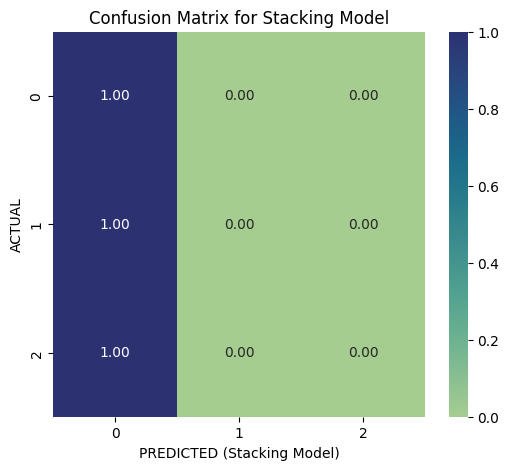

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Predictions

# 2. Print Classification Report
print("Stacking Model Classification Report:")
print(classification_report(y_stacking, stacking_predictions))

# 3. Generate and display Confusion Matrix
cf_stacking = confusion_matrix(y_stacking, stacking_predictions, normalize='true')
plt.figure(figsize=(6, 5))
sns.heatmap(cf_stacking, annot=True, cmap='crest', fmt='.2f')
plt.xlabel('PREDICTED (Stacking Model)')
plt.ylabel('ACTUAL')
plt.title('Confusion Matrix for Stacking Model')
plt.show()

LoRA-enabled RoBERTa Model Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93        83
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00        11

    accuracy                           0.86        96
   macro avg       0.29      0.33      0.31        96
weighted avg       0.75      0.86      0.80        96



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


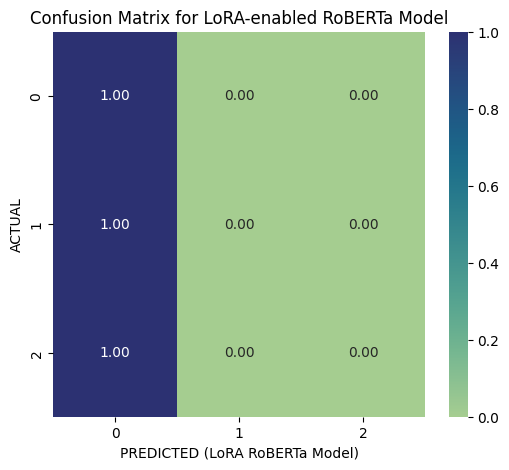

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Convert probability predictions from LoRA-enabled RoBERTa model to class labels
lora_predicted_labels = np.argmax(lora_predictions_proba, axis=-1)

# 2. Print Classification Report
print("LoRA-enabled RoBERTa Model Classification Report:")
print(classification_report(val_labels, lora_predicted_labels))

# 3. Confusion Matrix
cf_lora = confusion_matrix(val_labels, lora_predicted_labels, normalize='true')
plt.figure(figsize=(6, 5))
sns.heatmap(cf_lora, annot=True, cmap='crest', fmt='.2f')
plt.xlabel('PREDICTED (LoRA RoBERTa Model)')
plt.ylabel('ACTUAL')
plt.title('Confusion Matrix for LoRA-enabled RoBERTa Model')
plt.show()

LoRA-enabled RoBERTa Model Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93        83
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00        11

    accuracy                           0.86        96
   macro avg       0.29      0.33      0.31        96
weighted avg       0.75      0.86      0.80        96



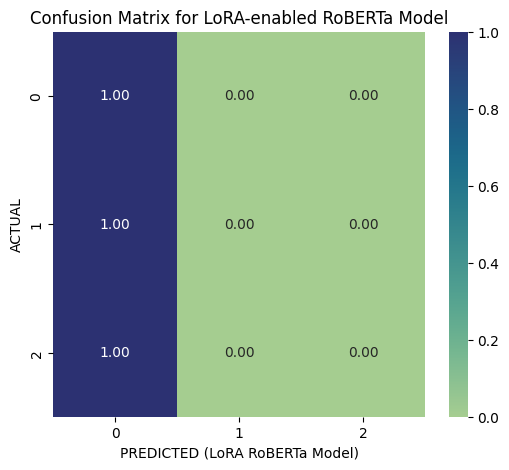

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Convert probability predictions from LoRA-enabled RoBERTa model to class labels
lora_predicted_labels = np.argmax(lora_predictions_proba, axis=-1);

# 2. Print Classification Report
print("LoRA-enabled RoBERTa Model Classification Report:")
print(classification_report(val_labels, lora_predicted_labels, zero_division=0))

# 3.Confusion Matrix
cf_lora = confusion_matrix(val_labels, lora_predicted_labels, normalize='true')
plt.figure(figsize=(6, 5))
sns.heatmap(cf_lora, annot=True, cmap='crest', fmt='.2f')
plt.xlabel('PREDICTED (LoRA RoBERTa Model)')
plt.ylabel('ACTUAL')
plt.title('Confusion Matrix for LoRA-enabled RoBERTa Model')
plt.show()

RoBERTa Base Model Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93        83
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00        11

    accuracy                           0.86        96
   macro avg       0.29      0.33      0.31        96
weighted avg       0.75      0.86      0.80        96



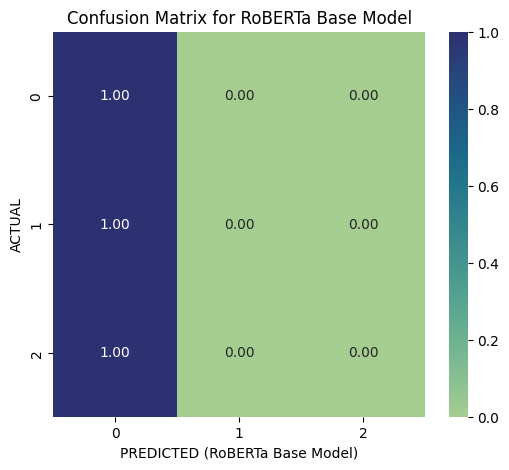

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Convert probability predictions from RoBERTa base model to class labels
roberta_base_predicted_labels = np.argmax(roberta_base_predictions_proba, axis=-1)

# 2. Print Classification Report
print("RoBERTa Base Model Classification Report:")
print(classification_report(val_labels, roberta_base_predicted_labels, zero_division=0))

# 3. Confusion Matrix
cf_roberta_base = confusion_matrix(val_labels, roberta_base_predicted_labels, normalize='true')
plt.figure(figsize=(6, 5))
sns.heatmap(cf_roberta_base, annot=True, cmap='crest', fmt='.2f')
plt.xlabel('PREDICTED (RoBERTa Base Model)')
plt.ylabel('ACTUAL')
plt.title('Confusion Matrix for RoBERTa Base Model')
plt.show()

BiLSTM Model Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93        83
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00        11

    accuracy                           0.86        96
   macro avg       0.29      0.33      0.31        96
weighted avg       0.75      0.86      0.80        96



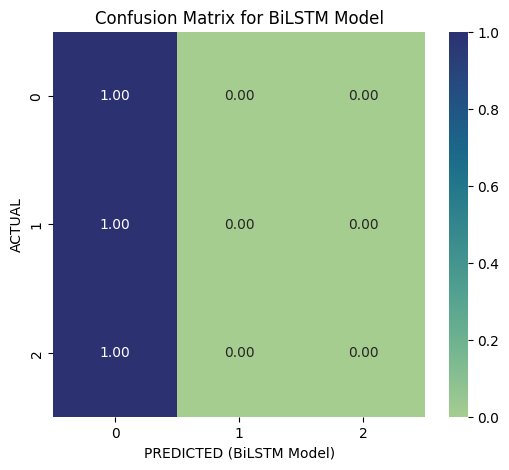

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Convert probability predictions from BiLSTM model to class labels
bilstm_predicted_labels = np.argmax(bilstm_predictions_proba, axis=-1)

# 2. Print Classification Report for BiLSTM model
print("BiLSTM Model Classification Report:")
print(classification_report(y_test, bilstm_predicted_labels, zero_division=0))

# 3. Confusion Matrix for BiLSTM model
cf_bilstm = confusion_matrix(y_test, bilstm_predicted_labels, normalize='true')
plt.figure(figsize=(6, 5))
sns.heatmap(cf_bilstm, annot=True, cmap='crest', fmt='.2f')
plt.xlabel('PREDICTED (BiLSTM Model)')
plt.ylabel('ACTUAL')
plt.title('Confusion Matrix for BiLSTM Model')
plt.show()

In [ ]:
vocab_size = 50000
dimension = 100
sentence_length = 200


one_hot_comments = [one_hot(str(word), vocab_size) for word in df['final_comment'].fillna('')]

# Pad the sequences
embedded_comments = pad_sequences(one_hot_comments, padding='pre', maxlen=sentence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    embedded_comments,
    df['class'],
    test_size=0.2,
    random_state=42
)

print(f"vocab_size: {vocab_size}")
print(f"dimension (embedding_dim): {dimension}")
print(f"sentence_length (max_sequence_length): {sentence_length}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

vocab_size: 50000
dimension (embedding_dim): 100
sentence_length (max_sequence_length): 200
Shape of X_train: (383, 200)
Shape of X_test: (96, 200)
Shape of y_train: (383,)
Shape of y_test: (96,)


In [ ]:
import numpy as np
from tensorflow import keras

# Re-create the Keras BiLSTM model architecture using the defined parameters
bilstm_model = keras.Sequential([
    # Embedding layer
    keras.layers.Embedding(vocab_size, dimension, input_length = sentence_length),
    # LSTM layers
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50),
    # Output layer
    keras.layers.Dense(num_labels, activation = 'softmax') # Use num_labels for output classes
])

# Compile the BiLSTM model
bilstm_model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# Train the BiLSTM model
print("Training BiLSTM model...")
bilstm_model.fit(X_train, y_train, epochs = 10, batch_size=32, verbose=0) # verbose=0 to suppress epoch output
print("BiLSTM model trained.")

# Generate probability predictions from the BiLSTM model on X_test
bilstm_predictions_proba = bilstm_model.predict(X_test)

print("BiLSTM model predictions generated.")
print(f"Shape of BiLSTM predictions: {bilstm_predictions_proba.shape}")
print("First 5 predictions (probabilities per class):\n", bilstm_predictions_proba[:5])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training BiLSTM model...
